## The Analysis of The Evolution of The Russian Comedy. Part 3.

In this analysis,we will explore evolution of the French five-act comedy in verse based on the following features:

- The coefficient of dialogue vivacity;
- The percentage of scenes with split verse lines;
- The percentage of scenes with split rhymes;
- The percentage of open scenes.
- The percentage of scenes with split verse lines and rhymes.

We will tackle the following questions:
1. We will describe the features;
2. We will explore feature correlations.
3. We will check the features for normality using Shapiro-Wilk normality test. This will help us determine whether parametric vs. non-parametric statistical tests are more appropriate. If the features are not normally distributed, we will use non-parametric tests. 
4. In our previous analysis of Sperantov's data, we discovered that instead of four periods of the Russian five-act tragedy in verse proposed by Sperantov, we can only be confident in the existence of two periods, where 1795 is the cut-off year. Therefore, we propose the following periods for the Russian verse comedy:
 - Period One (from 1775 to 1794)
 - Period Two (from 1795 to 1849).
5. We will run statistical tests to determine whether these two periods are statistically different.
6. We will create visualizations for each feature.
7. We will run descriptive statistics for each feature.

In [1]:
import pandas as pd
import numpy as np
import json
from os import listdir
from scipy.stats import shapiro
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [2]:
def make_plot(feature, title):
    mean, std, median = summary(feature)
    plt.figure(figsize=(10, 7))
    plt.title(title, fontsize=17)
    sns.distplot(feature, kde=False)
    mean_line = plt.axvline(mean, 
                            color='black',
                            linestyle='solid', 
                            linewidth=2); M1 = 'Mean';
    median_line = plt.axvline(median, 
                               color='green',linestyle='dashdot', 
                               linewidth=2); M2='Median'
    std_line = plt.axvline(mean + std, 
                           color='black',
                           linestyle='dashed', 
                           linewidth=2); M3 = 'Standard deviation';
    plt.axvline(mean - std, 
                color='black',
                linestyle='dashed', 
                linewidth=2)

    plt.legend([mean_line, median_line, std_line], [M1, M2, M3])
    plt.show()

In [3]:
def small_sample_mann_whitney_u_test(series_one, series_two):
    values_one = series_one.sort_values().tolist()
    values_two = series_two.sort_values().tolist()
    # make sure there are no ties  - this function only works for no ties
    result_df = pd.DataFrame(values_one + values_two, columns=['combined']).sort_values(by='combined')
    # average for ties
    result_df['ranks'] = result_df['combined'].rank(method='average')
    # make a dictionary where keys are values and values are ranks
    val_to_rank = dict(zip(result_df['combined'].values, result_df['ranks'].values))
    sum_ranks_one = np.sum([val_to_rank[num] for num in values_one])
    sum_ranks_two = np.sum([val_to_rank[num] for num in values_two])
    # number in sample one and two
    n_one = len(values_one) 
    n_two = len(values_two)
    # calculate the mann whitney u statistic which is the smaller of the u_one and u_two
    u_one = ((n_one * n_two) + (n_one * (n_one + 1) / 2)) - sum_ranks_one
    u_two = ((n_one * n_two) + (n_two * (n_two + 1) / 2)) - sum_ranks_two                     
    # add a quality check 
    assert u_one + u_two == n_one * n_two
    u_statistic = np.min([u_one, u_two])
    
    return u_statistic

In [4]:
def summary(feature):
    mean = feature.mean()
    std = feature.std()
    median = feature.median()
    
    return mean, std, median

In [5]:
# updated boundaries
def determine_period(row):
    if row <= 1794:
        period = 1
    else:
        period = 2
    
    return period

## Part 1. Feature Descriptions

For the Russian corpus of the five-act comedies, we generated additional features that were mentioned by Iarkho. So far, we had no understanding how these features evolved over time and whether they could differentiate literary periods.
 
The features include the following:
1. **The Coefficient of Dialogue Vivacity**, i.e., the number of utterances in a play / the number of verse lines in a play. Since some of the comedies in our corpus were written in iambic hexameter while others were written in free iambs, it is important to clarify how we made sure the number of verse lines was comparable. Because Aleksandr Groboedov's *Woe From Wit* the only five-act comedy in verse that had an extensive markup, we used it as the basis for our calculation. 
    - First, corrected the Dracor's markup of the verse lines;
    - Next, we calculated the number of verse lines in *Woe From Wit*, which was 2220;
    - Then, we calculated the total number of syllables in *Woe From Wit*, which was 22076;
    - We calculated the average number of syllables per verse line: 22076 / 2220 = 9.944144144144143;
    - Finally, we divided the average number of syllables in *Woe From Wit* by the average number of syllables in a comedy written in hexameter, i.e., 12.5: 9.944144144144143 / 12.5 = 0.796;
    - To convert the number of verse lines in a play written in free iambs and make it comparable with the comedies written in hexameter, we used the following formula: rescaled_number of verse lines = the number of verse lines in free iams * 0.796. 
    - For example, in *Woe From Wit*, the number of verse lines = 2220, the rescaled number of verse lines = 2220 * 0.796 = 1767.12. The coefficient of dialogue vivacity = 702 / 1767.12 = 0.397.   
2. **The Percentage of Scenes With Split Verse Lines**, i.e, the percentage of scenes where the end of a scene does not correspond with the end of a verse lines and the verse line extends into the next scene, e.g., Не бойся. Онъ блажитъ. ЯВЛЕНІЕ 3. Какъ радъ что вижу васъ.
3. **The Percentage of Scenes With Split Rhymes**, i.e., the percentage of scenes that rhyme with other scenes, e.g.Надѣюсъ на тебя, Вѣтрана, какъ на стѣну. ЯВЛЕНІЕ 4. И въ ней , какъ ни крѣпка, мы видимЪ перемѣну.
4. **The Percentage of Open Scenes**, i.e., the percentage of scenes with either split verse lines or rhymes.
5. **The Percentage of Scenes With Split Verse Lines and Rhymes**, i.e., the percentage of scenes that are connected through both means: by sharing a verse lines and a rhyme.

In [6]:
comedies = pd.read_csv('../Russian_Comedies/Data/Comedies_Raw_Data.csv')

In [7]:
# sort by creation date
comedies_sorted = comedies.sort_values(by='creation_date').copy()

In [8]:
# select only original comedies and five act
original_comedies = comedies_sorted[(comedies_sorted['translation/adaptation'] == 0) & 
                                   (comedies_sorted['num_acts'] == 5)].copy()

In [9]:
original_comedies.head()

,index,title,first_name,last_name,creation_date,translation/adaptation,num_acts,free_iambs,num_present_characters,num_scenes_text,...,percentage_open_scenes,percentage_scenes_rhymes_split_verse,num_stage_directions,stage_directions_frequency,num_word_tokens_in_stage_directions,average_length_of_stage_direction,num_verse_splitting_stage_directions,degree_of_verse_prose_interaction,number_scenes_with_discontinuous_change_characters,percentage_scenes_with_discontinuous_change_characters
0,R_1,Samoliubivyi stikhotvorets,Nikolai,Nikolev,1775,0,5,0,8,37,...,65.217,17.391,406,24.458,1102,2.714,161,9.699,3,6.667
1,R_2,Khvastun,Iakov,Kniazhnin,1785,0,5,0,14,50,...,47.273,14.545,356,17.298,893,2.508,104,5.053,2,3.636
3,R_4,Prestupnik ot igry ili bratom prodannaia sestra,Dmitrii,Efim’ev,1788,0,5,0,8,43,...,48.077,11.538,299,22.669,782,2.615,90,6.823,5,9.615
2,R_3,Chudaki,Iakov,Kniazhnin,1790,0,5,0,15,44,...,51.667,6.667,386,16.489,1078,2.793,139,5.938,2,3.333
4,R_5,Smekh i gore,Aleksandr,Klushin,1792,0,5,0,9,56,...,6.667,3.333,255,14.522,771,3.024,64,3.645,4,6.667


In [10]:
original_comedies.shape

(16, 38)

In [11]:
# rename column names for clarity
original_comedies = original_comedies.rename(columns={'num_scenes_iarkho': 'mobility_coefficient'})

In [12]:
comedies_verse_features = original_comedies[['index',
                                   'title',
                                   'first_name',
                                   'last_name',
                                   'creation_date',
                                   'dialogue_vivacity',
                                   'percentage_scene_split_verse',
                                   'percentage_scene_split_rhymes',
                                   'percentage_open_scenes',
                                   'percentage_scenes_rhymes_split_verse']].copy()

In [13]:
comedies_verse_features.head()

,index,title,first_name,last_name,creation_date,dialogue_vivacity,percentage_scene_split_verse,percentage_scene_split_rhymes,percentage_open_scenes,percentage_scenes_rhymes_split_verse
0,R_1,Samoliubivyi stikhotvorets,Nikolai,Nikolev,1775,0.465,30.435,52.174,65.217,17.391
1,R_2,Khvastun,Iakov,Kniazhnin,1785,0.478,27.273,34.545,47.273,14.545
3,R_4,Prestupnik ot igry ili bratom prodannaia sestra,Dmitrii,Efim’ev,1788,0.367,23.077,36.538,48.077,11.538
2,R_3,Chudaki,Iakov,Kniazhnin,1790,0.437,11.667,46.667,51.667,6.667
4,R_5,Smekh i gore,Aleksandr,Klushin,1792,0.458,3.333,6.667,6.667,3.333


## Part 1. Feature Correlations

In [14]:
comedies_verse_features[['dialogue_vivacity',
                       'percentage_scene_split_verse',
                       'percentage_scene_split_rhymes',
                       'percentage_open_scenes',
                       'percentage_scenes_rhymes_split_verse']].corr().round(2)

,dialogue_vivacity,percentage_scene_split_verse,percentage_scene_split_rhymes,percentage_open_scenes,percentage_scenes_rhymes_split_verse
dialogue_vivacity,1.00,0.53,0.51,0.45,0.73
percentage_scene_split_verse,0.53,1.00,0.66,0.86,0.87
percentage_scene_split_rhymes,0.51,0.66,1.00,0.92,0.81
percentage_open_scenes,0.45,0.86,0.92,1.00,0.82
percentage_scenes_rhymes_split_verse,0.73,0.87,0.81,0.82,1.00


In [15]:
original_comedies[['dialogue_vivacity',
                  'mobility_coefficient']].corr()

,dialogue_vivacity,mobility_coefficient
dialogue_vivacity,1.000000,0.061944
mobility_coefficient,0.061944,1.000000


Dialogue vivacity is moderately positively correlated with the percentage of scenes with split verse lines (0.53), with the percentage of scenes with split rhymes (0.51), and slightly less correlated with the percentage of open scenes (0.45). However, it is strongly positively correlated with the percentage of scenes with both split rhymes and verse lines (0.73). The scenes with very fast-paced dialogue are more likely to be interconnected through both rhyme and shared verse lines. One unexpected discovery is that dialogue vivacity only weakly correlated with the mobility coefficient (0.06): more active movement of dramatic characters on stage does not necessarily entail that their utterances are going to be shorter.

The percentage of scenes with split verse lines is moderately positively correlated with the percentage of scenes with split rhymes (0.66): the scenes that are connected by verse are likely but not necessarily always going to be connected through rhyme.

Such features as the percentage of open scenes and the percentage of scenes with split rhymes and verse lines are strongly positively correlated with their constituent features (the correlation of the percentage of open scenes with the percentage of scenes with split verse lines is 0.86, with the percentage of split rhymes is 0.92). From this, we can infer that the bulk of the open scenes are connected through rhymes. The percentage of scenes with split rhymes and verse lines is strongly positively correlated with the percentage of scenes with split verse lines (0.87) and the percentage of scenes with split rhymes.

## Part 3. Feature Distributions and Normality

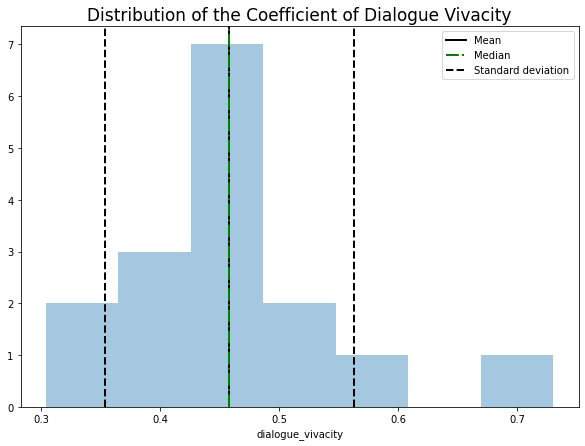

In [16]:
make_plot(comedies_verse_features['dialogue_vivacity'], 
         'Distribution of the Coefficient of Dialogue Vivacity')

### Shapiro-Wilk Normality Test

In [17]:
print('The p-value of the Shapiro-Wilk normality test:', 
      shapiro(comedies_verse_features['dialogue_vivacity'])[1])

The p-value of the Shapiro-Wilk normality test: 0.2067030817270279


The Shapiro-Wilk test showed that the probability of the coefficient of dialogue vivacity of being normally distributed is 0.2067030817270279, which is above the 0.05 significance level. We fail to reject the null hypothesis of the normal distribution.

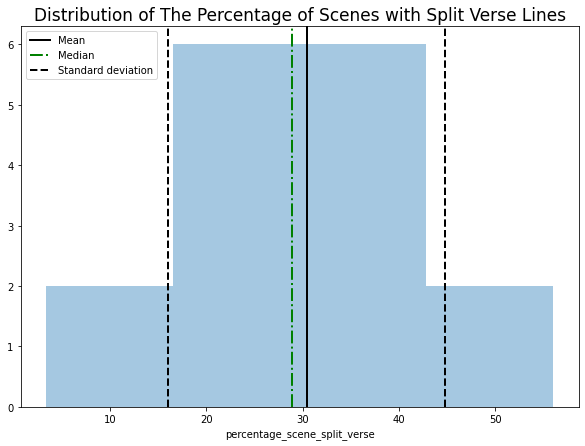

In [18]:
make_plot(comedies_verse_features['percentage_scene_split_verse'], 
         'Distribution of The Percentage of Scenes with Split Verse Lines')

In [19]:
print('The p-value of the Shapiro-Wilk normality test:', 
      shapiro(comedies_verse_features['percentage_scene_split_verse'])[1])

The p-value of the Shapiro-Wilk normality test: 0.8681985139846802


The Shapiro-Wilk showed that the probability of the percentage of scenes with split verse lines of being normally distributed is very high (the p-value is 0.8681985139846802). We fail to reject the null hypothesis of normal distribution.

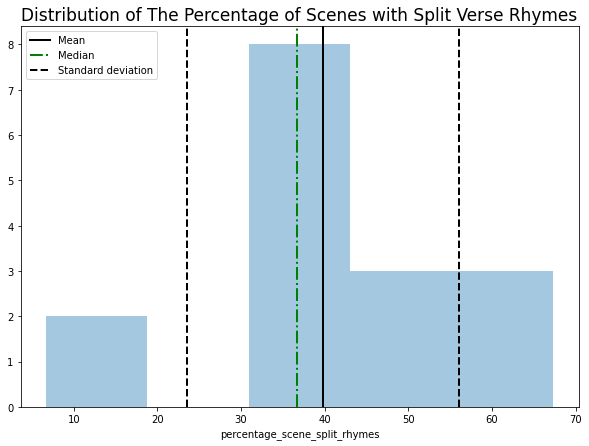

In [20]:
make_plot(comedies_verse_features['percentage_scene_split_rhymes'], 
       'Distribution of The Percentage of Scenes with Split Verse Rhymes')

In [21]:
print('The p-value of the Shapiro-Wilk normality test:', 
      shapiro(comedies_verse_features['percentage_scene_split_rhymes'])[1])

The p-value of the Shapiro-Wilk normality test: 0.5752763152122498


The Shapiro-Wilk test showed that the probability of the number of dramatic characters of being normally distributed is 0.5752763152122498. This probability is much higher than the 0.05 significance level. Therefore, we fail to reject the null hypothesis of normal distribution.

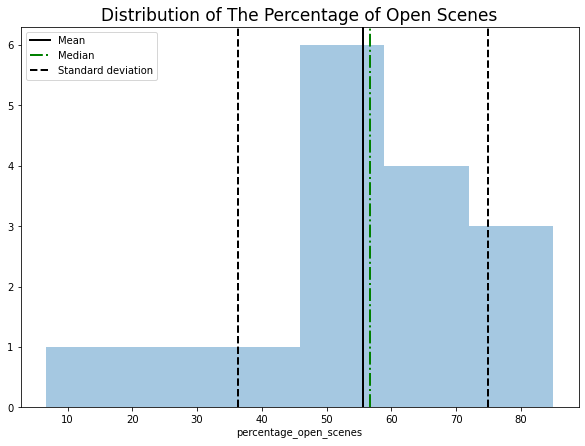

In [22]:
make_plot(comedies_verse_features['percentage_open_scenes'], 
        'Distribution of The Percentage of Open Scenes')

In [23]:
print('The p-value of the Shapiro-Wilk normality test:', 
      shapiro(comedies_verse_features['percentage_open_scenes'])[1])

The p-value of the Shapiro-Wilk normality test: 0.3018988370895386


The Shapiro-Wilk test showed that the probability of the number of the percentage of open scenes of being normally distributed is 0.3018988370895386, which is quite a lot higher than the significance level of 0.05. Therefore, we fail to reject the null hypothesis of normal distribution of the percentage of open scenes.

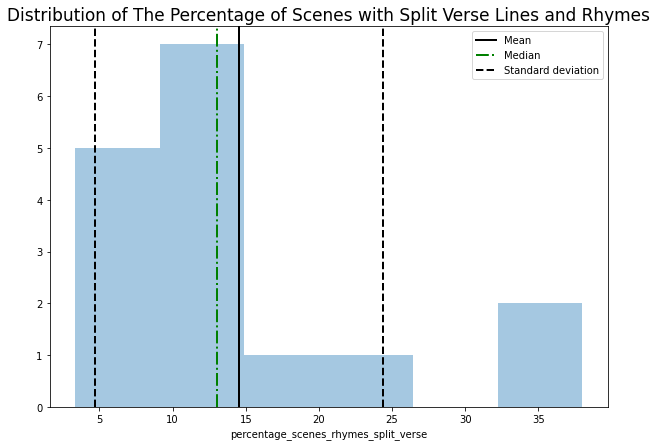

In [24]:
make_plot(comedies_verse_features['percentage_scenes_rhymes_split_verse'], 
        'Distribution of The Percentage of Scenes with Split Verse Lines and Rhymes')

In [25]:
print('The p-value of the Shapiro-Wilk normality test:', 
      shapiro(comedies_verse_features['percentage_scenes_rhymes_split_verse'])[1])

The p-value of the Shapiro-Wilk normality test: 0.015218793414533138


The Shapiro-Wilk test showed that the probability of the percentage of scenes with split verse lines and rhymes of being normally distributed is very low (the p-value is 0.015218793414533138). Therefore, we reject the hypothesis of normal distribution.

### Summary:
1. The majority of the verse features are normally distributed. For them, we can use a parametric statistical test.
2. The only feature that is not normally distributed is the percentage of scenes with split rhymes and verse lines. For this feature, we will use a non-parametric test such as the Mann-Whitney test.

## Part 3. Hypothesis Testing

We will run statistical tests to determine whether the two periods distinguishable for the Russian five-act verse tragedy are significantly different for the Russian five-act comedy. The two periods are:
 - Period One (from 1747 to 1794)
 - Period Two (from 1795 to 1822)
 
For two features that are normally distributed (the percentage of polylogue and the percentage of monologues), we will use *scipy.stats* Python library to run a **t-test** to check whether there is a difference between Period One and Period Two. The null hypothesis is that there is no difference between the two periods. The alternative hypothesis is that the two periods are different, Our significance level will be set at 0.05. If the p-value produced by the t-test will be below 0.05. We will reject the null hypothesis of no difference. 


For the percentage of scenes with split rhymes and verse lines, we will run **the Mann-Whitney u-test** to check whether there is a difference between Period One and Period Two. The null hypothesis will be no difference between these periods, whereas the alternative hypothesis will be that the periods will be different.

Since most of the periods have fewer than 20 tragedies, we cannot use the scipy's Man-Whitney u-test that requires each sample size to be at least 20 because it uses normal approximation. Instead, we will have to run Mann-Whitney U-test without a normal approximation for which we wrote a custom function. The details about the test can be found in the following resource: https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_nonparametric/bs704_nonparametric4.html.

One limitation that we need to mention is the sample size. The first period has only six comedies and the second period has only ten. However, it is impossible to increase the sample size - we cannot ask the Russian playwrights of the eighteenth and nineteenth century to produce more five-act verse comedies.

In [26]:
comedies_verse_features['period'] = comedies_verse_features.creation_date.apply(determine_period)

In [27]:
period_one = comedies_verse_features[comedies_verse_features['period'] == 1].copy()
period_two = comedies_verse_features[comedies_verse_features['period'] == 2].copy()

In [28]:
period_one.shape

(6, 11)

In [29]:
period_two.shape

(10, 11)

## The T-Test

### The Coefficient of Dialogue Vivacity

In [30]:
from scipy.stats import ttest_ind

In [31]:
ttest_ind(period_one['dialogue_vivacity'],
          period_two['dialogue_vivacity'], equal_var=False)

Ttest_indResult(statistic=-0.09702821154686758, pvalue=0.9241932201090827)

### The Percentage of Scenes With Split Verse Lines

In [32]:
ttest_ind(period_one['percentage_scene_split_verse'],
          period_two['percentage_scene_split_verse'], equal_var=False)

Ttest_indResult(statistic=-3.0690182591339266, pvalue=0.00930746440942179)

### The Percentage of Scnes With Split  Rhymes

In [33]:
ttest_ind(period_one['percentage_scene_split_rhymes'],
          period_two['percentage_scene_split_rhymes'], equal_var=False)

Ttest_indResult(statistic=-0.808517305550233, pvalue=0.43553543917756476)

### The Percentage of Open Scenes

In [34]:
ttest_ind(period_one['percentage_open_scenes'],
          period_two['percentage_open_scenes'], equal_var=False)

Ttest_indResult(statistic=-1.8278590884499197, pvalue=0.10023096313507399)

### Summary

|Feature                    |p-value               |Result
|---------------------------| ----------------|--------------------------------
|  The coefficient of dialogue vivacity |0.92 | Not Significant
|The percentage of scenes with split verse lines|0.009 | Significant
|The percentage of scenes with split rhymes| 0.44| Not significant
|The percentage of open scenes| 0.10| Not significant

## The Mann-Whitney Test

The Process:
- Our null hypothesis is that there is no difference between two periods. Our alternative hypothesis is that the periods are different.
- We will set the signficance level (alpha) at 0.05.
- We will run the test and calculate the test statistic.
- We will compare the test statistic with the critical value of U for a two-tailed test at alpha=0.05. Critical values can be found at https://www.real-statistics.com/statistics-tables/mann-whitney-table/.
- If our test statistic is equal or lower than the critical value of U, we will reject the null hypothesis. Otherwise, we will fail to reject it.

### The Percentage of Scenes With Split Verse Lines and Rhymes

In [35]:
small_sample_mann_whitney_u_test(period_one['percentage_scenes_rhymes_split_verse'],
                                 period_two['percentage_scenes_rhymes_split_verse'])

21.0

### Critical Value of U

|Periods                      |Critical Value of U              
|---------------------------| ----------------
|  Period One (n=6) and Period Two (n=10) |11


### Summary

|Feature                    |u-statistic              |Result
|---------------------------| ----------------|--------------------------------
|  The percentage of scenes with split verse lines and rhymes|21 | Not Significant

For comedies, Period One and Period Two are only significantly different based on the percentage of scenes with split verse lines. Based on other features, we cannot reject the null hypothesis of no difference between the two periods.

## Part 4. Visualizations

In [36]:
def scatter(df, feature, title, xlabel, text_y):
    sns.jointplot('creation_date', 
               feature,
               data=df, 
               color='b', 
               height=7).plot_joint(
               sns.kdeplot, 
               zorder=0, 
               n_levels=20)
    plt.axvline(1795, color='grey',linestyle='dashed', linewidth=2)
    plt.text(1795.5, text_y, '1795')
    plt.title(title, fontsize=20, pad=100)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(xlabel, fontsize=14)

    plt.show()

### The Coefficient of Dialogue Vivacity

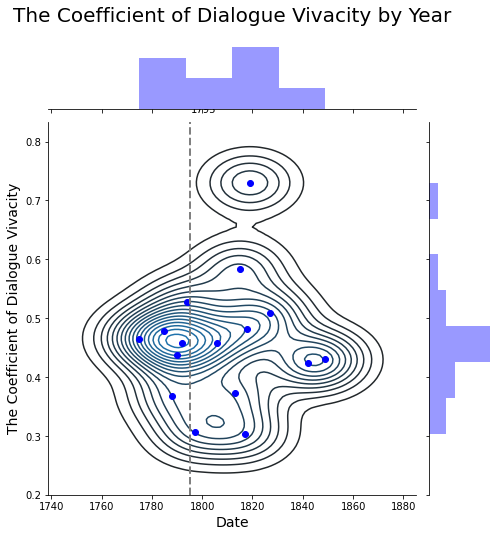

In [37]:
scatter(comedies_verse_features, 
        'dialogue_vivacity', 
        'The Coefficient of Dialogue Vivacity by Year', 
        'The Coefficient of Dialogue Vivacity',
        0.85)

### The Percentage of Scenes With Split Verse Lines

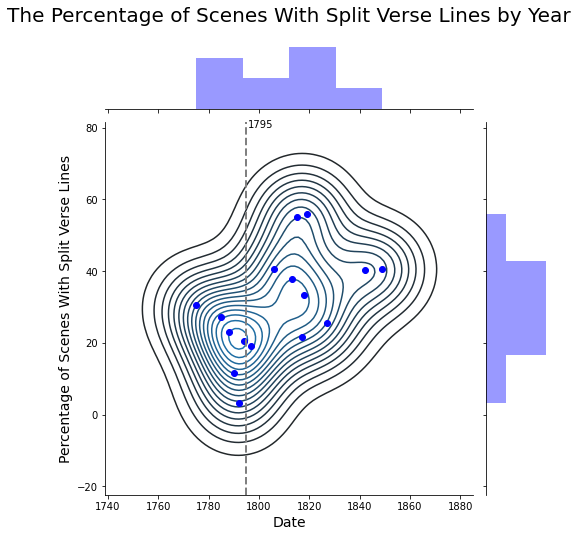

In [38]:
scatter(comedies_verse_features, 
        'percentage_scene_split_verse', 
        'The Percentage of Scenes With Split Verse Lines by Year', 
        'Percentage of Scenes With Split Verse Lines',
         80)

### The Percentage of Scenes With Split  Rhymes

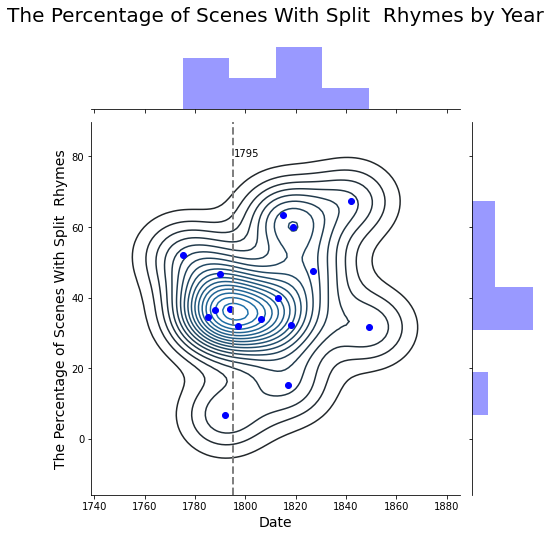

In [39]:
scatter(comedies_verse_features, 
        'percentage_scene_split_rhymes', 
        'The Percentage of Scenes With Split  Rhymes by Year', 
        'The Percentage of Scenes With Split  Rhymes',
         80)

### The Percentage of Open Scenes

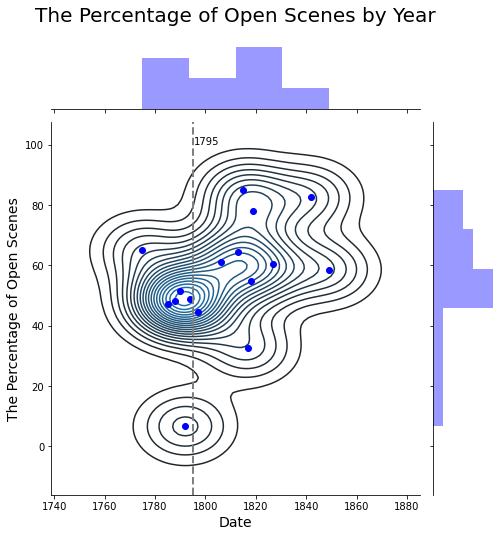

In [40]:
scatter(comedies_verse_features, 
        'percentage_open_scenes', 
        'The Percentage of Open Scenes by Year', 
        'The Percentage of Open Scenes',
         100)

### The Percentage of Scenes With Split Verse Lines and Rhymes

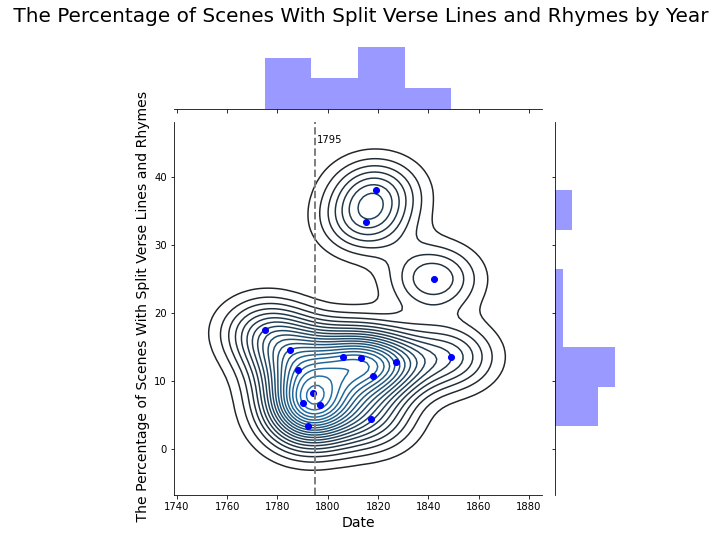

In [41]:
scatter(comedies_verse_features, 
        'percentage_scenes_rhymes_split_verse', 
        ' The Percentage of Scenes With Split Verse Lines and Rhymes by Year', 
        ' The Percentage of Scenes With Split Verse Lines and Rhymes',
         45)

## Part 5. Descriptive Statistics For Two Periods and Overall

### The Coefficient of Dialogue Vivacity

#### In Entire Corpus

In [42]:
['dialogue_vivacity',
                       'percentage_scene_split_verse',
                       'percentage_scene_split_rhymes',
                       'percentage_open_scenes',
                       'percentage_scenes_rhymes_split_verse']

['dialogue_vivacity',
 'percentage_scene_split_verse',
 'percentage_scene_split_rhymes',
 'percentage_open_scenes',
 'percentage_scenes_rhymes_split_verse']

In [43]:
comedies_verse_features.describe().loc[:, 'dialogue_vivacity'][['mean', 
                                                                    'std', 
                                                                    '50%',
                                                                    'min', 
                                                                    'max']].round(2)

mean    0.46
std     0.10
50%     0.46
min     0.30
max     0.73
Name: dialogue_vivacity, dtype: float64

#### By  Tentative Periods

In [44]:
comedies_verse_features.groupby('period').describe().loc[:, 'dialogue_vivacity'][['mean', 
                                                                                'std', 
                                                                                '50%',
                                                                                'min', 
                                                                                'max']].round(2)

,mean,std,50%,min,max
period,,,,,
1,0.46,0.05,0.46,0.37,0.53
2,0.46,0.13,0.44,0.30,0.73


### The Percentage of Scenes With Split Verse Lines

#### In Entire Corpus

In [45]:
comedies_verse_features.describe().loc[:, 'percentage_scene_split_verse'][['mean', 
                                                                    'std', 
                                                                    '50%',
                                                                    'min', 
                                                                    'max']].round(2)

mean    30.39
std     14.39
50%     28.85
min      3.33
max     56.00
Name: percentage_scene_split_verse, dtype: float64

#### By Periods

In [46]:
comedies_verse_features.groupby('period').describe().loc[:, 'percentage_scene_split_verse'][['mean', 
                                                                                    'std', 
                                                                                    '50%',
                                                                                    'min', 
                                                                                    'max']].round(2)

,mean,std,50%,min,max
period,,,,,
1,19.37,10.16,21.74,3.33,30.44
2,37.00,12.57,39.08,19.15,56.00


### The Percentage of Scenes With Split Rhymes

In [47]:
comedies_verse_features.describe().loc[:, 'percentage_scene_split_rhymes'][['mean', 
                                                                            'std', 
                                                                            '50%',
                                                                            'min', 
                                                                            'max']].round(2)

mean    39.77
std     16.24
50%     36.64
min      6.67
max     67.31
Name: percentage_scene_split_rhymes, dtype: float64

#### By Tentative Periods

In [48]:
comedies_verse_features.groupby('period').describe().loc[:, 'percentage_scene_split_rhymes'][['mean', 
                                                                                            'std', 
                                                                                            '50%',
                                                                                            'min', 
                                                                                            'max']].round(2)

,mean,std,50%,min,max
period,,,,,
1,35.55,15.73,36.64,6.67,52.17
2,42.30,16.82,36.95,15.22,67.31


### The Percentage of Open Scenes

#### In Entire Corpus

In [49]:
comedies_verse_features.describe().loc[:, 'percentage_open_scenes'][['mean', 
                                                                    'std', 
                                                                    '50%',
                                                                    'min', 
                                                                    'max']].round(2)

mean    55.62
std     19.25
50%     56.66
min      6.67
max     85.00
Name: percentage_open_scenes, dtype: float64

#### By Tenative Periods

In [50]:
comedies_verse_features.groupby('period').describe().loc[:,  'percentage_open_scenes'][['mean', 
                                                                                        'std', 
                                                                                        '50%',
                                                                                        'min', 
                                                                                        'max']].round(2)

,mean,std,50%,min,max
period,,,,,
1,44.65,19.76,48.53,6.67,65.22
2,62.21,16.50,60.67,32.61,85.00


### The Percentage of Scenes With Split Verse Lines or Rhymes

In [51]:
comedies_verse_features.describe().loc[:, 'percentage_scenes_rhymes_split_verse'][['mean', 
                                                                                    'std', 
                                                                                    '50%',
                                                                                    'min', 
                                                                                    'max']].round(2)

mean    14.53
std      9.83
50%     13.02
min      3.33
max     38.00
Name: percentage_scenes_rhymes_split_verse, dtype: float64

In [52]:
comedies_verse_features.groupby('period').describe().loc[:,  'percentage_scenes_rhymes_split_verse'][['mean', 
                                                                                                    'std', 
                                                                                                    '50%',
                                                                                                    'min', 
                                                                                                    'max']].round(2)

,mean,std,50%,min,max
period,,,,,
1,10.27,5.22,9.85,3.33,17.39
2,17.09,11.25,13.42,4.35,38.00


### Summary:
1. The mean dialogue vivacity in the corpus of the Russian five-act comedy in verse was 0.46, with the 0.10 standard deviation. In the tentative Period One, the mean dialogue vivacity was 0.46, the same as in the tentative Period Two. The standard deviation increased from 0.05 in the tentative Period One to 0.13 in the tentative Period Two.
2. The mean percentage of scenes with split verse lines in the corpus was 30.39%, with a standard deviation of 14.39. In Period One, the mean percentage of scenes with split verse lines was 19.37%, with a standard deviation of 10.16. In Period Two, the mean percentage of scenes with split verse lines almost doubled to 37%, with a standard deviation of 12.57%.
3. The average percentage of scenes with split verses was higher in the entire corpus of the Russian five-act comedies in verse than the average percentage of scenes with split verse lines (39.77% vs. 30.39%). The standard deviation was 16.24%. Based on this feature, the difference between tentative periods was not as pronounced: 35.55 in the tentative Period One, with a standard deviation of 15.73% and 42.30% in the tentative Period Two, with a standard deviation of 16.82.
4. In the corpus, on average 55.62% of the scenes were open, i.e., more than half of all scenes were connected either through rhyme or verse lines. The standard deviation was 19.25%. In the tentative Period One, the percentage of open scenes was 44.65%, with a standard deviation of 19.76. In the tentative Period Two, the percentage of open scenes increased to 62.21%, with a standard deviation of 16.50%, i.e., the standard deviation was lower in Period Two.
5. For the corpus, only 14.53% of all scenes were connected through both rhymes and verse lines. The standard deviation was 9.83%. In the tentative Period One, the mean percentage of scenes with split verse lines and rhymes was 10.27%, with a standard deviation of 5.22. In the tentative Period Two, the mean percentage of scenes with split verse lines and rhymes was 17.09, with a much higher standard deviation of 11.25.


## Conclusions:
1. The majority of the examined features were normally distributed, with the only exception of the percentage of scenes with split verse lines and rhymes.
2. The distribution of the percentage of scenes with split verse lines different significantly between Period One (from 1775 to 1794) and Period Two (from 1795 to 1849)). 
2. For other verse features, there is no evidence to suggest that the two periods of the Russian five-act comedy in verse are significantly different.
3. The mean values of all examined features increased from tentative Period One to Period Two. The standard deviation of all examined features (except for the percentage of open scenes) increased from Period One to Period Two.
4. Judging by the natural clustering in the data, 1805 maybe a more appropriate boundary between the two time periods for comedy.